# Implementing Mapping Types


[Click here to run this chapter on Colab](https://colab.research.google.com/github/AllenDowney/DSIRP/blob/main/notebooks/hashmap.ipynb)

## Analysis of search algorithms

A **search** is an algorithm that takes a collection and a target item
and determines whether the target is in the collection, often returning
the index of the target.

The simplest search algorithm is a "linear search", which traverses the
items of the collection in order, stopping if it finds the target. In
the worst case it has to traverse the entire collection, so the run time
is linear.

The `in` operator for sequences uses a linear search; so do string
methods like `find` and `count`.

If the elements of the sequence are in order, you can use a **bisection
search**, which is $O(\log n)$. Bisection search is similar to the
algorithm you might use to look a word up in a dictionary (a paper
dictionary, not the data structure). Instead of starting at the
beginning and checking each item in order, you start with the item in
the middle and check whether the word you are looking for comes before
or after. If it comes before, then you search the first half of the
sequence. Otherwise you search the second half. Either way, you cut the
number of remaining items in half.

If the sequence has 1,000,000 items, it will take about 20 steps to find
the word or conclude that it's not there. So that's about 50,000 times
faster than a linear search.

Bisection search can be much faster than linear search, but it requires
the sequence to be in order, which might require extra work.

There is another data structure, called a **hashtable** that is even
faster---it can do a search in constant time---and it doesn't require
the items to be sorted. Python dictionaries are implemented using
hashtables, which is why most dictionary operations, including the `in`
operator, are constant time.

## LinearMap

To explain how hashtables work and why their performance is so good, I
start with a simple implementation of a map and gradually improve it
until it's a hashtable.

I use Python to demonstrate these implementations, but in real life you
wouldn't write code like this in Python; you would just use a
dictionary! So this notebook, you have to imagine that
dictionaries don't exist and you want to implement a data structure that
maps from keys to values. 

The operations we'll implement are:

* `add(k, v)`: Add a new item that maps from key `k` to value `v`. With a Python dictionary, `d`, this operation is written `d[k] = v`.

* `get(k)`: Look up and return the value that corresponds to key `k`. With a Python dictionary, `d`, this operation is written `d[k]` or `d.get(k)`.

For now, I assume that each key only appears once. 

Here's a simple implementation of this interface using a list of tuples, where each tuple is a key-value pair.

In [1]:
items = []

key = 'a'
value = 1
items.append((key, value))

items.append(('b', 2))

target = 'b'
for k, v in items:
    if k == target:
        print(v)



In [2]:
items = []

def add(k, v):
    items.append((k, v))

add('a', 1)
add('b', 2)

def get(target):
    for key, val in items:
        if key == target:
            print(val)

get('b')


In [3]:
class LinearMap:
    def __init__(self):
        self.items = []
        
lmap = LinearMap()
lmap.items

In [4]:
class LinearMap:

    def __init__(self):
        self.items = []

    def add(self, k, v):
        self.items.append((k, v))

    def get(self, target):
        for k, v in self.items:
            if k == target:
                return v
        raise KeyError(f'{target} not found')

`__init__` creates a new map with an empty list of items, so that's constant time.

`add` appends a key-value tuple to the list of items, which takes
constant time.

`get` uses a `for` loop to search the list: if it finds the target key
it returns the corresponding value; otherwise it raises a `KeyError`. So
`get` is linear.

Let's try out this implementation.

In [5]:
import string

lmap = LinearMap()

for i, c in enumerate(string.ascii_lowercase):
    lmap.add(c, i)

lmap.get('x')

An alternative is to keep the list sorted by key. Then `get` could use a
bisection search, which is $O(\log n)$. But inserting a new item in the
middle of a list is linear, so this might not be the best option. 

We could also use a binary search tree, which can implement ` add` and `get` in log time, but that's still not as good as constant time, so let's move on.

## BetterMap

One way to improve `LinearMap` is to break the list of key-value pairs
into smaller lists. Here's an implementation called `BetterMap`, which
is a list of 100 LinearMaps. As we'll see in a second, the order of
growth for `get` is still linear, but `BetterMap` is a step on the path
toward hashtables:

In [6]:
class BetterMap:

    def __init__(self, n=100):
        self.maps = [LinearMap() for i in range(100)]

    def find_map(self, k):
        index = hash(k) % len(self.maps)
        return self.maps[index]

    def add(self, k, v):
        m = self.find_map(k)
        m.add(k, v)

    def get(self, k):
        m = self.find_map(k)
        return m.get(k)

`__init__` makes a list of `LinearMap` objects.

`find_map` is used by `add` and `get` to figure out which map to put the
new item in, or which map to search.

`find_map` uses the built-in function `hash`, which takes almost any
Python object and returns an integer. A limitation of this
implementation is that it only works with hashable keys. Mutable types
like lists and dictionaries are unhashable.

Hashable objects that are considered equivalent return the same hash
value, but the converse is not necessarily true: two objects with
different values can return the same hash value.

`find_map` uses the modulus operator to wrap the hash values into the
range from 0 to `len(self.maps)`, so the result is a legal index into
the list. Of course, this means that many different hash values will
wrap onto the same index. But if the hash function spreads things out
pretty evenly (which is what hash functions are designed to do), then we
expect $n/100$ items per `LinearMap`.

Let's try it out:

In [7]:
bmap = BetterMap()

for i, c in enumerate(string.ascii_lowercase):
    bmap.add(c, i)

bmap.get('x')

In [8]:
for lmap in bmap.maps:
    print(len(lmap.items))

Since the run time of `LinearMap.get` is proportional to the number of
items, we expect BetterMap to be about 100 times faster than LinearMap.
The order of growth is still linear, but the leading coefficient is
smaller.

## Hash Functions

`BetterMap.find_map` uses the [built-in function `hash`](https://docs.python.org/3/library/functions.html#hash), which takes any hashable object and returns an integer:


> `hash(object)`
>
> Return the hash value of the object (if it has one). Hash values are integers. They are used to quickly compare dictionary keys during a dictionary lookup. Numeric values that compare equal have the same hash value (even if they are of different types, as is the case for 1 and 1.0).

In [1]:
from fractions import Fraction

hash(2), hash(2.0), hash(2 + 0j), hash(Fraction(4, 2))

(2, 2, 2, 2)

In [10]:
t = 2,
hash(t)

In [11]:
try:
    hash([2])
except TypeError as e:
    print(e)

In [12]:
hash('2')

## HashMap

Here (finally) is the crucial idea that makes hashtables fast: if you
can keep the maximum length of the LinearMaps bounded, ` LinearMap.get`
is constant time. All you have to do is keep track of the number of
items and when the number of items per LinearMap exceeds a threshold,
resize the hashtable by adding more LinearMaps.

Here is an implementation of a hashtable:

In [13]:
class HashMap:

    def __init__(self):
        self.bmap = BetterMap(2)
        self.num = 0

    def get(self, k):
        return self.bmap.get(k)

    def add(self, k, v):
        if self.num == len(self.bmap.maps):
            self.resize()

        self.bmap.add(k, v)
        self.num += 1

    def resize(self):
        new_bmap = BetterMap(len(self.bmap.maps) * 2)

        for m in self.bmap.maps:
            for k, v in m.items:
                new_bmap.add(k, v)

        self.bmap = new_bmap

`__init__` creates a `BetterMap` and initializes `num`, which keeps
track of the number of items.

`get` just invokes `BetterMap.get`, which uses `find_map` to figure out which `LinearMap` to search. 

The real work happens in `add`, which checks the number of items and the size of the `BetterMap`: if they are equal, the average number of items per LinearMap is 1, so it calls `resize`.

`resize` makes a new `BetterMap`, twice as big as the previous one, and
then "rehashes" the items from the old map to the new.

In [14]:
hmap = HashMap()

for i, c in enumerate(string.ascii_lowercase):
    hmap.add(c, i)

hmap.get('x')

Rehashing is necessary because changing the number of `LinearMap` objects changes the denominator of the modulus operator in `find_map`. That means that some objects that used to hash into the same LinearMap will get split up (which is what we wanted, right?).

Rehashing is linear, so `resize` is linear, which might seem bad, since
I promised that `add` would be constant time. But remember that we don't
have to resize every time, so `add` is usually constant time and only
occasionally linear. The total amount of work to run `add` $n$ times is
proportional to $n$, so the average time of each `add` is constant time!

To see how this works, think about starting with an empty `HashTable` and adding a sequence of items. We start with 2 `LinearMap` objects, so the first 2 adds are fast (no resizing required). Let's say that they take one unit of work each. The next add requires a resize, so we have to rehash the first two items (let's call that 2 more units of work) and then add the third item (one more unit). Adding the next item costs 1 unit, so the total so far is 6 units of work for 4 items.

The next `add` costs 5 units, but the next three are only one unit each,
so the total is 14 units for the first 8 adds.

The next `add` costs 9 units, but then we can add 7 more before the next
resize, so the total is 30 units for the first 16 adds.

After 32 adds, the total cost is 62 units, and I hope you are starting
to see a pattern. After $n$ adds, where $n$ is a power of two, the total
cost is $2n-2$ units, so the average work per add is a little less than
2 units. When $n$ is a power of two, that's the best case; for other
values of $n$ the average work is a little higher, but that's not
important. The important thing is that it is $O(1)$.

The following figure shows
how this works graphically. Each block represents a unit of work. The
columns show the total work for each add in order from left to right:
the first two adds cost 1 unit each, the third costs 3 units, etc.

![](https://github.com/AllenDowney/DSIRP/raw/main/figs/towers.png)

The extra work of rehashing appears as a sequence of increasingly tall
towers with increasing space between them. Now if you knock over the
towers, spreading the cost of resizing over all adds, you can see
graphically that the total cost after $n$ adds is $2n - 2$.

An important feature of this algorithm is that when we resize the
`HashTable` it grows geometrically; that is, we multiply the size by a
constant. If you increase the size arithmetically---adding a fixed
number each time---the average time per `add` is linear.


## Run Time

For the implementation of a dictionary, a good hash function is one that spreads out the values so the number of items in each of the `LinearMap` objects is about the same.

In the worst case, if the hash function returns the same value for all objects, they would all be in the same `LinearMap`, and the `get` operation would be linear.

Hash functions can be expensive to compute, especially if the keys are large objects (like long strings, for example).
So dictionaries are "fast" because the operations are constant time, but they can be "slow" because the leading constant is relatively high.

If the number of items in the dictionary is small, other implementations might be faster.

**Exercise:** What are the orders of growth for these two functions? Which one is faster when the words are 11 letters long?

In [12]:
from collections import Counter

def is_anagram2(word1, word2):
    return Counter(word1) == Counter(word2)

In [13]:
def is_anagram3(word1, word2):
    return sorted(word1) == sorted(word2)

In [29]:
%timeit is_anagram2('tachymetriaaaaaabab', 'mccaaarthyizzzzdx_t')

3.1 µs ± 13.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [28]:
%timeit is_anagram3('tachymetriaaaaaabab', 'mccaaarthyizzzzdx_t')

1.38 µs ± 5.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


is_anagram 3 is much faster when using timeit.
The graphs both return linear-looking graphs, but for time complexity:
**is_anagram2**
Construction for Counter->(n)
Comparing the two dictionaries is a time complexity of O(1) tthat can degenerate into o(n)
Highest rate of growth is O(n)
**is_anagram3**
Sorting a string rate of growth is nlogn
Comparing two strings is O(n)
highest rate of growth is O(nlogn)

In [32]:
%timeit is_anagram3('tachymetriaaaaaababbafgggggggggagadfggadfgadfaabababbbbbbctachymetricaaaaaabbbbbbbaffdgadfgabbabababa', 'mccaaggggggggggggggggggggggggggggestaertaerteartterarthyizzzzdx_teagdgfabbbbbbbbbaaaabbxc')

8.42 µs ± 37.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [33]:
%timeit is_anagram2('tachymetriaaaaaababbafgggggggggagadfggadfgadfaabababbbbbbctachymetricaaaaaabbbbbbbaffdgadfgabbabababa', 'mccaaggggggggggggggggggggggggggggestaertaerteartterarthyizzzzdx_teagdgfabbbbbbbbbaaaabbxc')

7.1 µs ± 24.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


However, whewhen we increase the amount of characters, is_anagram 3 eventually overtakes is_anagram 2's time to run  it has a higher growth rate

In [ ]:
Markdown

In [7]:
import os

def etime():
    """Measures user and system time this process has used.

    Returns the sum of user and system time."""
    user, sys, chuser, chsys, real = os.times()
    return user+sys

In [8]:
def fit(ns, ts, exp=1.0, index=-1):
    """Fits a curve with the given exponent.

    ns: sequence of problem sizes
    ts: sequence of times
    exp: exponent of the fitted curve
    index: index of the element the fitted line should go through

    returns: sequence of fitted times


    """
    # Use the element with the given index as a reference point,
    # and scale all other points accordingly.
    nref = ns[index]
    tref = ts[index]

    tfit = []
    for n in ns:
        ratio = n / nref
        t = ratio**exp * tref
        tfit.append(t)

    return tfit

In [9]:
from matplotlib import pyplot as plt

In [10]:
def time_func(func, n):
    """Run a function and return the elapsed time.

    func: function
    n: problem size, passed as an argument to func

    returns: user+sys time in seconds
    """
    start = etime()
    #modify for anagram
    func(n[0], n[1])
    end = etime()
    elapsed = end - start
    return elapsed

In [11]:
def plot_timing_test(ns, ts, label='', color='C0', exp=1.0, scale='log'):
    """Plots data and a fitted curve.

    ns: sequence of n (problem size)
    ts: sequence of t (run time)
    label: string label for the data curve
    color: string color for the data curve
    exp: exponent (slope) for the fitted curve
    scale: string passed to xscale and yscale
    """
    ts_fit = fit(ns, ts, exp)
    fit_label = 'exp = %d' % exp
    plt.plot(ns, ts_fit, label=fit_label, color='0.7', linestyle='dashed')
    plt.plot(ns, ts, 'o-', label=label, color=color, alpha=0.7)
    plt.xlabel('Problem size (n)')
    plt.ylabel('Runtime (seconds)')
    plt.xscale(scale)
    plt.yscale(scale)
    plt.legend()

In [1]:
import string

In [2]:
import random

In [3]:
def run_timing_test(func, max_time=1):
    """Tests the given function with a range of values for n.

    func: function object

    returns: list of ns and a list of run times.
    """
    ns = []
    ts = []
    for i in range(10, 28):
        n = 2**i
        t = time_func(func, ("ananrn333".join(random.choices(string.ascii_letters, k=n)), "nn4nr4b".join(random.choices(string.ascii_letters, k=n))))
        print(n, t)
        if t > 0:
            ns.append(n)
            ts.append(t)
        if t > max_time: 
            break

    return (ns, ts)

In [24]:
sa = run_timing_test(is_anagram2)


1024 0.0
2048 0.0
4096 0.015625
8192 0.0
16384 0.015625
32768 0.015625
65536 0.046875
131072 0.078125
262144 0.140625
524288 0.265625
1048576 0.5625
2097152 1.109375


In [79]:
sa

([1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144],
 [0.009999999999999787,
  0.019999999999999574,
  0.05000000000000249,
  0.06999999999999673,
  0.14000000000000057,
  0.32000000000000206,
  0.6199999999999992,
  0.9100000000000001,
  1.8600000000000012])

1024 0.0
2048 0.0
4096 0.0
8192 0.015625
16384 0.015625
32768 0.03125
65536 0.078125
131072 0.171875
262144 0.34375
524288 0.703125
1048576 1.421875


Text(0.5, 1.0, 'anagram 3')

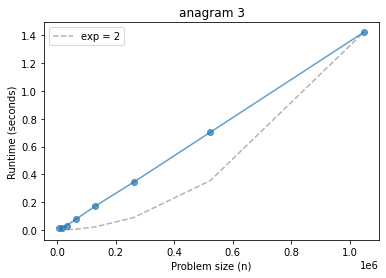

In [27]:
sa = run_timing_test(is_anagram3)
plot_timing_test(sa[0], sa[1], scale='linear', exp=2)
plt.title('anagram 3')

1024 0.0
2048 0.0
4096 0.0
8192 0.015625
16384 0.0
32768 0.015625
65536 0.03125
131072 0.078125
262144 0.140625
524288 0.296875
1048576 0.59375
2097152 1.171875


Text(0.5, 1.0, 'anagram 3')

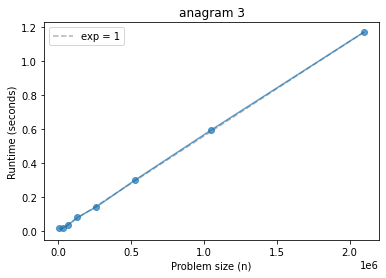

In [26]:



sa = run_timing_test(is_anagram2)
plot_timing_test(sa[0], sa[1], scale='linear', exp=1)
plt.title('anagram 3')

In [93]:
%timeit is_anagram3('tachymetric', 'mccarthyite')

1.66 µs ± 258 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


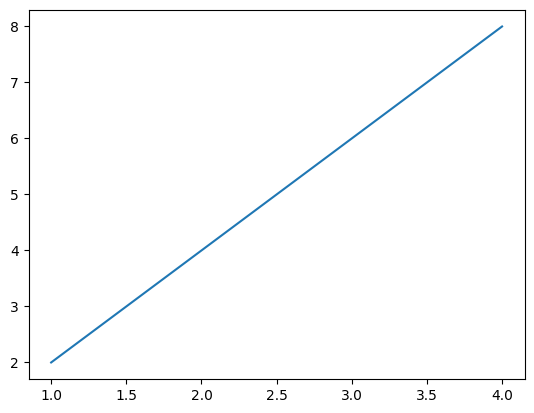

In [7]:

plt.plot([1,2,3,4],[2,4,6,8])


*Data Structures and Information Retrieval in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)